## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these tests.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# creating the mask to obtain rows with either 'treatment' or 'new_page' but not with both
mask_or = ((df['group'] == 'treatment') | (df['landing_page'] == 'new_page'))
mask_not_and = np.logical_not((df.group == 'treatment') & (df.landing_page == 'new_page'))

df[np.logical_and(mask_or, mask_not_and)].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any(axis=1).value_counts()

False    294478
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#excluding the rows where 'treatment' and 'new_page' don't match each other
df2 = df[np.logical_not(np.logical_and(mask_or, mask_not_and))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.value_counts()[df2.user_id.value_counts() > 1].index.tolist()

[773192]

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id == df2.user_id.value_counts()[df2.user_id.value_counts() > 1].index.tolist()[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id', keep='first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2.group == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2.group == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

In [18]:
# computing the difference between the proportions of 
# converted users in treatmeant and control groups

df2[df2.group == 'treatment'].converted.mean() - df2[df2.group == 'control'].converted.mean()

-0.0015782389853555567

Since the conversion rate of the old version is almost equal to (even slightly lower than) the conversion rate of the new version, it seems unlikely, that the new version is doing better than old one. But this needs to be tested.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$H_{0}$:  $p_{new}$ - $p_{old}$ $\leq$ 0  
$H_{1}$:  $p_{new}$ - $p_{old}$ > 0  

For the Type I error rate of 5% in one-tailed hypothesis we should set the confidence level at 0.05 and check whether the observed difference falls in the top 5% of the sampling distribution or not.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# p_new is equal to the converted success rate regardless of page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
# p_old is equal to the converted success rate regardless of page
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2.group == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2.group == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
random.seed(42)
new_page_converted = np.random.binomial(1, p_new, size=n_new)
new_page_converted.mean()

0.1192760305553644

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
random.seed(42)
old_page_converted = np.random.binomial(1, p_old, size=n_old)
old_page_converted.mean()

0.12056527664964137

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
sim_diff = new_page_converted.mean() - old_page_converted.mean()
sim_diff

-0.001289246094276969

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new, size=n_new)
    old_page_converted = np.random.binomial(1, p_old, size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

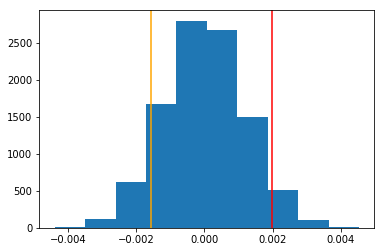

In [27]:
plt.hist(p_diffs)

# plotting confidence level limit
plt.axvline(np.percentile(p_diffs, 95), color = 'red')

# plotting observed difference in proportions in data
obs_diff = df2[df2.group == 'treatment'].converted.mean() - df2[df2.group == 'control'].converted.mean()
plt.axvline(obs_diff, color = 'orange');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.90820000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

In part **j** the p-value was calculated, which in this case means the probability of getting the observed difference in proportions - or higher - between the treatment and control groups from the sampling distribution simulated under the null: the hypothesis, that assumes that both groups have the same conversion rate. This value is much greater than the confidence level of 0.05 corresponding to the desired rate of 5% for Type I errors. This means that it is highly unlikely that the new page has higher conversion rate than the old one.

In case we are interested in proving if the conversion rate is not the same for treatment and control group - i.e. $H_{1}$:  $p_{new}$ - $p_{old}$ <> 0, and the alternative hypothesis is two-tailed, we need to check for both tails in our sampling distribution.

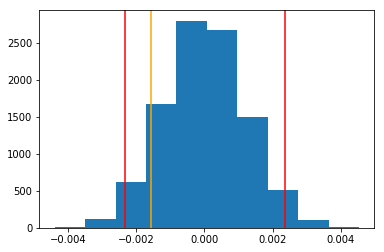

In [29]:
plt.hist(p_diffs)

# plotting confidence level limits for two-tailed hypothesis and confidence level of 0.05
plt.axvline(np.percentile(p_diffs, 2.5), color = 'red')
plt.axvline(np.percentile(p_diffs, 97.5), color = 'red')

# plotting observed difference in proportions in data
obs_diff = df2[df2.group == 'treatment'].converted.mean() - df2[df2.group == 'control'].converted.mean()
plt.axvline(obs_diff, color = 'orange');

In [30]:
null_mean = 0

p_val = (p_diffs < obs_diff).mean() + (p_diffs > (null_mean + (null_mean - obs_diff))).mean()
p_val

0.18820000000000001

Again, for two-tailed hypothesis the p-value is higher than the confidence level, which means that we have no evidence to assume that the observed difference doesn't some from the sampling distribution under the null.

---

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].shape[0]
n_new = df2[df2.group == 'treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
# the link isn't working, you know?

In [33]:
# for one-tailed hypothesis (if the convertion rate is larger for the new page)
z_score, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, pval

(-1.3109241984234394, 0.90505831275902449)

In [34]:
# for two-tailed hypothesis (if the convertion rate for the new page differs from one of the old page)
z_score, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')
z_score, pval

(-1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

Since the corresponding z-score for the confidence level of 0.05 is 1.65 for one-tailed hypothesis _"$H_{1}$:  $p_{new}$ - $p_{old}$ > 0"_ and either -1.96 or 1.96 for two-tailed hypothesis _"$H_{1}$:  $p_{new}$ - $p_{old}$ <> 0"_, we may conclude that the z-score of -1.31 for observed difference is not extreme enough for both cases and we fail to reject the null hypothesis, whether it is _"$H_{0}$:  $p_{new}$ - $p_{old}$ $\leq$ 0"_ or _"$H_{0}$:  $p_{new}$ - $p_{old}$ = 0"_. The p-value is about the same as we got through the simulation and also too high to reject the null for both cases, which confirms the results obtained in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**  
Logistic regression, since we are trying to predict one of two possible outcomes, and not a value in the infinite range of numbers.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1

In [36]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
import statsmodels.api as sm

logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:28:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**  
The p-value of 0.19 for `ab_page` is the same as the one obtained for the two-tailed z-test and close to the one obtained via simulation for the alternative hypothesis _"$H_{1}$:  $p_{new}$ - $p_{old}$ <> 0"_. It is again too high to reject the null hypothesis that the conversion rate is the same for the new page and the old page. That means that the coefficient for `ab_page` is not statistically significant.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

Since the only variable used in the logistic regression model above is not statistically significant to predict the corresponding outcome, it is only reasonable to explore other possible factors and use them to build a new model or to exhance the existing one. However, we need to check for possible relationships between explanatory variables to avoid the possible issues caused by these relationships, like multicollinearity. The logistic regression is based on the equation of linear regression, so we need to take into account the same assumptions.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

There are three countries in the dataframe, US being the most frequent option.

In [41]:
df2 = df2.join(countries, rsuffix = '_')
df2.drop('user_id_', axis = 1, inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         286742 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 28.0+ MB


In [42]:
df2.groupby('country').converted.mean()

country
CA    0.116870
UK    0.120250
US    0.119586
Name: converted, dtype: float64

The convertion rate in the US is closer to the overall conversion rate, since the US is the country that represents the majority of the dataset. The convertion rate in the UK is slightly higher and in Canada is slightly lower in comparison with the overall conversion rate.

In [43]:
# getting dummies for CA and UK; US is the baseline level
df2[['CA', 'UK']] = pd.get_dummies(df2['country'])[['CA', 'UK']]

In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1


In [45]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               6.153e-06
Time:                        20:28:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.5196
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9966      0.007   -293.134      0.000      -2.010      -1.983
CA            -0.0258      0.027     -0.959      0.337      -0.079       0.027
UK             0.0065      0.013      0.490      0.624      -0.020       0.033
==============================================================================
"""

The signs before the coefficients correspond to the directions of relationships described above. However, the p-values for both countries show that they don't demostrate statistically significant differences in conversion rate in comparison with the US, which is our baseline level and has the conversion rate close to the overall in the data set.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               1.420e-05
Time:                        20:28:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3884
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9891      0.009   -224.021      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0258      0.027     -0.959      0.338      -0.078       0.027
UK             0.0065      0.013      0.485      0.628      -0.020       0.033
==============================================================================
"""

As can be seen from the model summary, there is no benefits in terms of statistical significance in combining the page version variable and the country variable in one model: the p-values are still greater than 0.05 for each variable (or each level of variable for the categorical data).  

This again speaks in favor of keeping the old page: since we have no evidence of the new page performing better than the old page, it doesn't seem to be a better option from the practical point of view.  

Another option to consider is to continue the experiment to gather more data.

In [47]:
df2['timestamp'] = pd.to_datetime(df['timestamp'])

In [48]:
df2.timestamp.min(), df2.timestamp.max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:54.460509'))

For now the experiment was on for about 3 weeks, which may be not enough to overcome the change aversion.

In [49]:
df2.index = df2['timestamp']

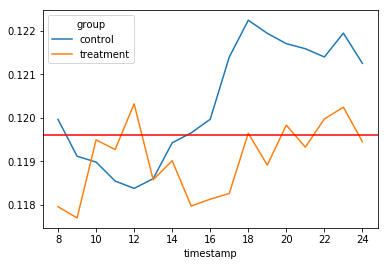

In [50]:
# calculating the rolling average for daily means and 7-day window
p = df2.groupby([df2.index.day, df2.group]).converted.mean().unstack('group').rolling(7).mean().plot();

# plotting overall conversion rate
p.axhline(df2.converted.mean(), color = 'red');

The plot doesn't seem to be very encouraging фищге the new page either. Still the final decision may also depend on the costs of continuing the experiment, on the typical traffic pattern in January in comparison with the other months of the year or the necessity to upgrade the page in term of technologies.

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0